<a href="https://colab.research.google.com/github/phaa/dio-baires-dev/blob/main/dio_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vamos começar importando as bibliotecas

In [2]:
%matplotlib inline

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Vamos importar o Kera do próprio tensorflow
from tensorflow import keras
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# Importamos um dataset personalizado de pragas

In [3]:
!git clone https://github.com/fenads/BairesDev-DIO.git

Cloning into 'BairesDev-DIO'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 225 (delta 3), reused 219 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (225/225), 35.11 MiB | 39.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Vamos validar as imagens que obtivemos do repositório externo

In [4]:
def validate_image(file_path):
    try:
        # Tenta converter a imagem em um tensor
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        return True # A imagem é compatível
    except:
        return False

dataset_path = '/content/BairesDev-DIO/Dataset-Pragas'
valid_files = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')) and validate_image(file_path):
            valid_files.append(file_path)
        else:
            print(f"Pulando arquivo inválido: {file_path}")

Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca82.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca89.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca85.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca102.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca86.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca92.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/Bicudo/bicudo70.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/Bicudo/bicudo74.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/Bicudo/bicudo26.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/Bicudo/bicudo20.png
Pulando arquivo inválido: /content/BairesDev-DIO/Dataset-Pragas/Bicudo/bicudo04.png
Pulando arquivo

In [5]:
# Se precisarmos ignorar alguma classe, colocamos o caminho de sua pasta aqui
exclude = []

categories = [root for root, dirs, files in os.walk(dataset_path) if root][1:]
filter = [os.path.join(dataset_path, e) for e in exclude]
categories = [c for c in categories if c not in filter]

print(categories)

['/content/BairesDev-DIO/Dataset-Pragas/MoscaBranca', '/content/BairesDev-DIO/Dataset-Pragas/Bicudo']


# Vamos criar funções para pré processar as imagens

In [6]:
# Essa função nos auxilia retornando a imagem carregada e o array de bytes
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr = preprocess_input(img_arr)
    return img, img_arr

# Carregando todas as imagens da pasta raiz

In [7]:
data = []
for cat_index, category in enumerate(categories):
    images = [
        os.path.join(root, filename) for root, dirs, filenames
        in os.walk(category) for filename in filenames
        if os.path.splitext(filename)[1].lower() in ['.jpg','.png','.jpeg']
    ]

    # Processando cada imagem encontrada
    for img_path in images:
        img, img_arr = get_image(img_path)
        data.append({'x': np.array(img_arr[0]), 'y': cat_index})

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Antes de dividir as imagens em conjuntos, vamos embaralhar todas elas

In [8]:
random.shuffle(data)

# Divisão de treinamento, validação e testes

In [9]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

### Separar os dados e suas labels

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]


### Ja que vamos treinar a nossa rede com gradiente, precisamos escalonar as caracteristicas de entrada

In [11]:
# Para obter valores entre 0 e 1, basta dividirmos pela maior intensidade de pixel
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convertendo as labels para one-hot encoding

In [12]:
# Vamos armazenar o número de classes
num_classes = len(categories)

# Com classificadores binários, utilizamos um array de classes
# 1 representa a presença da classe e 0 a ausencia no resultado
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(32, 2)


# Resumindo nosso conjunto de dados

In [13]:
print('Finalizado carregamento de {0} imagens de {1} categorias'.format(len(data), num_classes))
print('Treinamento: {0} | Validação {1} | Teste {2}'.format(len(x_train), len(x_val), len(x_test)))
print("Formato do conjunto de treinamento ", x_train.shape)
print("Formato do conjunto de treinamento ", y_train.shape)

Finalizado carregamento de 210 imagens de 2 categorias
Treinamento: 147 | Validação 31 | Teste 32
Formato do conjunto de treinamento  (147, 224, 224, 3)
Formato do conjunto de treinamento  (147, 2)


# Exibindo uma amostragem do conjunto de dados

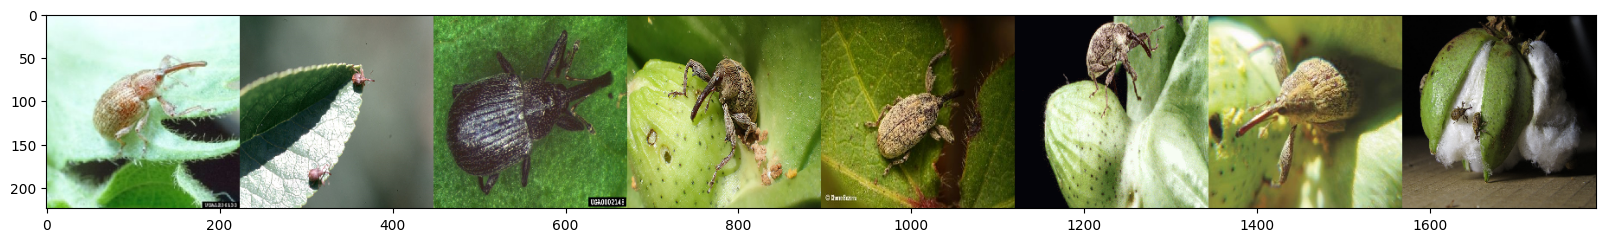

In [14]:
images = [
    os.path.join(root, filename) for root, dirs, filenames
    in os.walk(category) for filename in filenames
    if os.path.splitext(filename)[1].lower() in ['.jpg','.png','.jpeg']
]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(20,4))
plt.imshow(concat_image);

# Construindo a rede neural protótipo
Antes de construir uma rede com transfer learning, vamos criar uma do zero.
Assim poderemos comparar o desempenho de uma rede totalmente nova de uma outra
mais madura.

In [15]:
model = Sequential()
print("Dimensões de entrada: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Dimensões de entrada:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Vamos treinar o nosso modelo durante 20 épocas, usando a perda categorical cross-entropy e o otimizador Adaptive Moment Estimation para o gradiente descendente.

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.5068 - loss: 0.6998 - val_accuracy: 0.5484 - val_loss: 0.6488
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5230 - loss: 0.6799 - val_accuracy: 0.6452 - val_loss: 0.6393
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6801 - loss: 0.6132 - val_accuracy: 0.8387 - val_loss: 0.6036
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8391 - loss: 0.5288 - val_accuracy: 0.8065 - val_loss: 0.5200
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7670 - loss: 0.4766 - val_accuracy: 0.6129 - val_loss: 0.5895
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7177 - loss: 0.4804 - val_accuracy: 0.9355 - val_loss: 0.3464
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8988 - loss: 0.2787 - val_accuracy: 0.9032 - val_loss: 0.2836
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9007 - loss: 0.2492 - val_accuracy: 0.7419 - val_loss: 0.449

# Resultados do treinamento


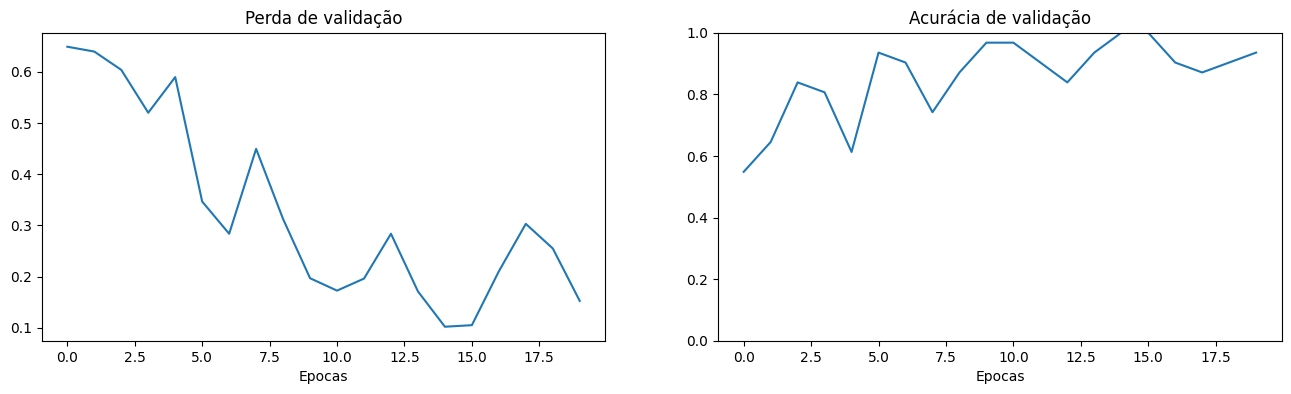

In [17]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Perda de validação")
ax.set_xlabel("Epocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Acurácia de validação")
ax2.set_xlabel("Epocas")
ax2.set_ylim(0, 1)

plt.show()

# Avaliando o modelo

In [18]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Perda no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

Perda no conjunto de testes: 0.19684341549873352
Acurácia no conjunto de testes: 0.90625


# Utilizando transfer learning
### Agora vamos utilizar uma rede neural pré treinada para classificar nossas próprias classes.
Vamos usar uma rede VGG do Keras que foi treinada com o dataset do ImageNet e teve seus pesos salvos online.

In [19]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# faz uma referência à camada de entrada da VGG
inp = vgg.input

# crie uma nova camada softmax com neurônios num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# conecte nossa nova camada à penúltima camada no VGG e faça uma referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# crie uma nova rede entre inp e out
model_new = Model(inp, out)

# tornar todas as camadas não treináveis ​​congelando os pesos (exceto a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garantir que a última camada seja treinável/não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [21]:
# Agora treinamos a nova rede
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=40,
                         validation_data=(x_val, y_val))

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 68s 31s/step - accuracy: 0.5256 - loss: 1.0686 - val_accuracy: 0.5484 - val_loss: 1.1661
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.5075 - loss: 1.2542 - val_accuracy: 0.4516 - val_loss: 0.7126
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.5198 - loss: 0.7353 - val_accuracy: 0.4516 - val_loss: 0.8791
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.4997 - loss: 0.8283 - val_accuracy: 0.6774 - val_loss: 0.5325
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.7288 - loss: 0.5598 - val_accuracy: 0.5484 - val_loss: 0.6359
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.5509 - loss: 0.6573 - val_accuracy: 0.8387 - val_loss: 0.4636
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.8527 - loss: 0.4705 - val_accuracy: 0.8065 - val_loss: 0.4291
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.8034 - loss: 0.4349 - val_accuracy: 0.8065 - val_loss: 

# Plotando o resultado final

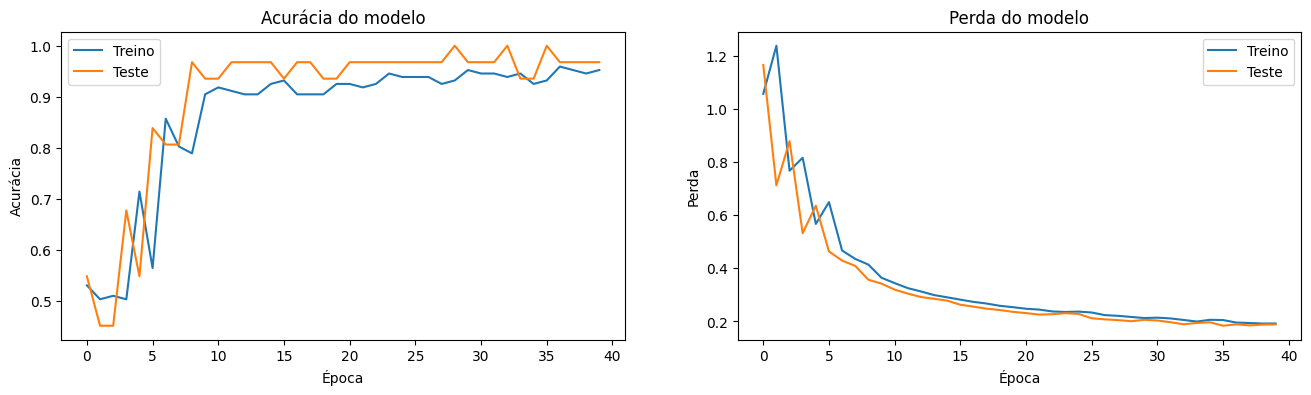

In [22]:
fig = plt.figure(figsize=(16,4))

# Histórico de acurácia
ax = fig.add_subplot(121)
ax.plot(history2.history['accuracy'])
ax.plot(history2.history['val_accuracy'])
ax.set_title('Acurácia do modelo')
ax.set_ylabel('Acurácia')
ax.set_xlabel('Época')
ax.legend(['Treino', 'Teste'], loc='upper left')

# Histórico de perda
ax2 = fig.add_subplot(122)
ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('Perda do modelo')
ax2.set_ylabel('Perda')
ax2.set_xlabel('Época')
ax2.legend(['Treino', 'Teste'], loc='upper right')

plt.show()

Através dos gráficos, podemos notar que as métricas de acurácia do conjunto de testes estão bem próximas do conjunto de treinamento, o que indica que não houve sobreajuste no modelo.  
# Avaliando as métricas do novo modelo

In [23]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print('Perda no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

Perda no conjunto de testes: 0.18732857704162598
Acurácia no conjunto de testes: 0.96875


In [40]:
img, x = get_image('/content/BairesDev-DIO/Dataset-Pragas/MoscaBranca/MoscaBranca04.png')
probabilities = model_new.predict([x])
split_categories = list(map(lambda cat: cat.split('/')[-1], categories))

for i in range(probabilities.size):
  print('{0}: {1}'.format(split_categories[i], probabilities[0][i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
MoscaBranca: 0.9995391368865967
Bicudo: 0.00046088150702416897
